In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import umap

from collections import Counter

import spacy

# load files and make corpus

In [2]:
with open('hansard-speeches-post2010-lemmatized-agg.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
with open('hansard-speeches-post2010.pkl', 'rb') as f:
    df_orig = pickle.load(f)

In [4]:
MP_party = df_orig[['display_as', 'party']]
MP_party = MP_party.drop_duplicates('display_as').set_index('display_as')

In [5]:
names = [x[2] for x in df.index.values]
parties = [MP_party.loc[MP_name].party for MP_name in names]

In [6]:
corpus = list(df.speech.values)
# corpus = list(df.lemmas.apply(lambda x: " ".join(x)).values)

# speech embedding

In [7]:
from sentence_transformers import SentenceTransformer

# embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embedder = SentenceTransformer('paraphrase-mpnet-base-v2')
# embedder = SentenceTransformer('stsb-mpnet-base-v2') #75 max seq length

## count prop. contributions with word/lemma counts above embedder max input sequence length

max sequence length: 128
wordcounts above 128: 33.859 %
lemmacounts above 128: 22.3978 %


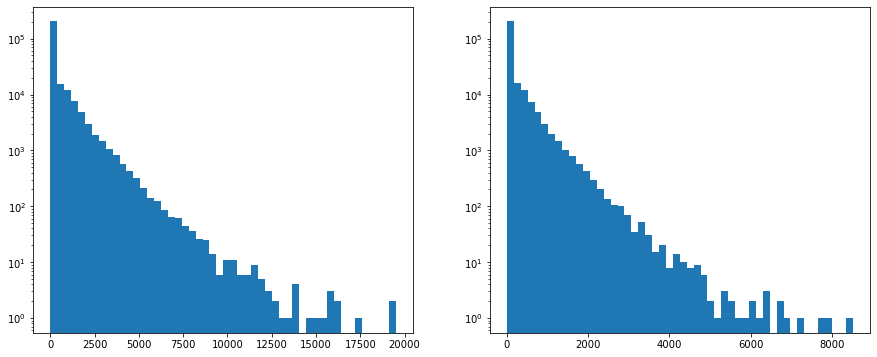

In [8]:
wordcount = df.speech.apply(lambda x: len(x.split())).values
lemmacount = df.lemmas.apply(len).values

max_seq_len = embedder.max_seq_length
print(f'max sequence length: {max_seq_len}')

fig, ax = plt.subplots(1,2,figsize=(15,6))

ax[0].hist(wordcount, bins=50)
ax[0].set_yscale('log')
print(f'wordcounts above {max_seq_len}: {np.around((np.sum(wordcount > max_seq_len) / len(wordcount))*100, 4)} %')

ax[1].hist(lemmacount, bins=50)
ax[1].set_yscale('log')
print(f'lemmacounts above {max_seq_len}: {np.around((np.sum(lemmacount > max_seq_len) / len(lemmacount))*100, 4)} %')

plt.show()

In [9]:
# don't run if loading embeddings
# corpus_embeddings = embedder.encode(corpus)
# corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

In [10]:
# don't run if loading embeddings
# with open('corpus_embeddings.pkl', 'wb') as f:
#     pickle.dump(corpus_embeddings, f)

# run to load embeddings
with open('corpus_embeddings.pkl', 'rb') as f:
    corpus_embeddings = pickle.load(f)

In [11]:
corpus_embeddings.shape

(253820, 768)

## PCA dimensionality reduction

In [12]:
from sklearn.decomposition import PCA
pca = PCA(random_state=26)
pca.fit(corpus_embeddings)

PCA(random_state=26)

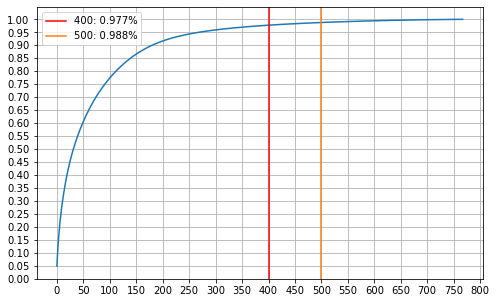

In [13]:
evr = pca.explained_variance_ratio_
cum_evr = [np.sum(evr[:i+1]) for i in range(len(evr))]



fig, ax = plt.subplots(figsize=(8,5))
ax.plot(cum_evr)
ax.grid()
ax.set_xticks(range(0,801,50))
ax.set_yticks(np.arange(0,1.05,0.05))

v = 400
ax.axvline(v, c='r', label=f'{v}: {np.around(cum_evr[v], 3)}%')

v = 500
ax.axvline(v, c='tab:orange', label=f'{v}: {np.around(cum_evr[v], 3)}%')

ax.legend()

plt.show()

In [14]:
# 400 dimensions corresponds to cumulative explained variance ratio of ~98%
embeddings = PCA(n_components=400, random_state=26).fit_transform(corpus_embeddings)

## umap dimensionality reduction

In [15]:
np.unique(parties)

array(['Alliance', 'Conservative', 'Democratic Unionist Party',
       'Green Party', 'Independent', 'Labour', 'Labour (Co-op)',
       'Liberal Democrat', 'Plaid Cymru', 'Respect',
       'Scottish National Party', 'Social Democratic & Labour Party',
       'Speaker', 'Ulster Unionist Party', 'nan'], dtype='<U32')

In [16]:
party_colormap = {
    'Alliance': '#F6CB2F',
    'Conservative': '#0087DC',
    'Democratic Unionist Party': '#D46A4C',
    'Green Party': '#6AB023',
    'Independent': '#DDDDDD',
    'Labour': '#E4003B',
    'Labour (Co-op)': '#E4003B',
    'Liberal Democrat': '#FAA61A',
    'Plaid Cymru': '#008142',
    'Scottish National Party': '#FDF38E',
    'Social Democratic & Labour Party': '#2AA82C',
    'Speaker': '#FFFFFF',
    'Respect': '#46801c',
    'Ulster Unionist Party': '#70147A',
    'nan': '#FFFFFF'
}

c = [party_colormap[str(x)] for x in parties]

In [17]:
# don't run if loading reduced embeddings
# reducer = umap.UMAP(n_neighbors=15, 
#                     min_dist=0,
#                     metric='cosine',
#                     low_memory=True)
# X = reducer.fit_transform(embeddings) # dimension reduced embedding

In [18]:
# don't run if loading reduced embeddings
# with open('umap_embeddings.pkl', 'wb') as f:
#     pickle.dump(X, f)

# run to load reduced embeddings
with open('umap_embeddings.pkl', 'rb') as f:
    X = pickle.load(f)

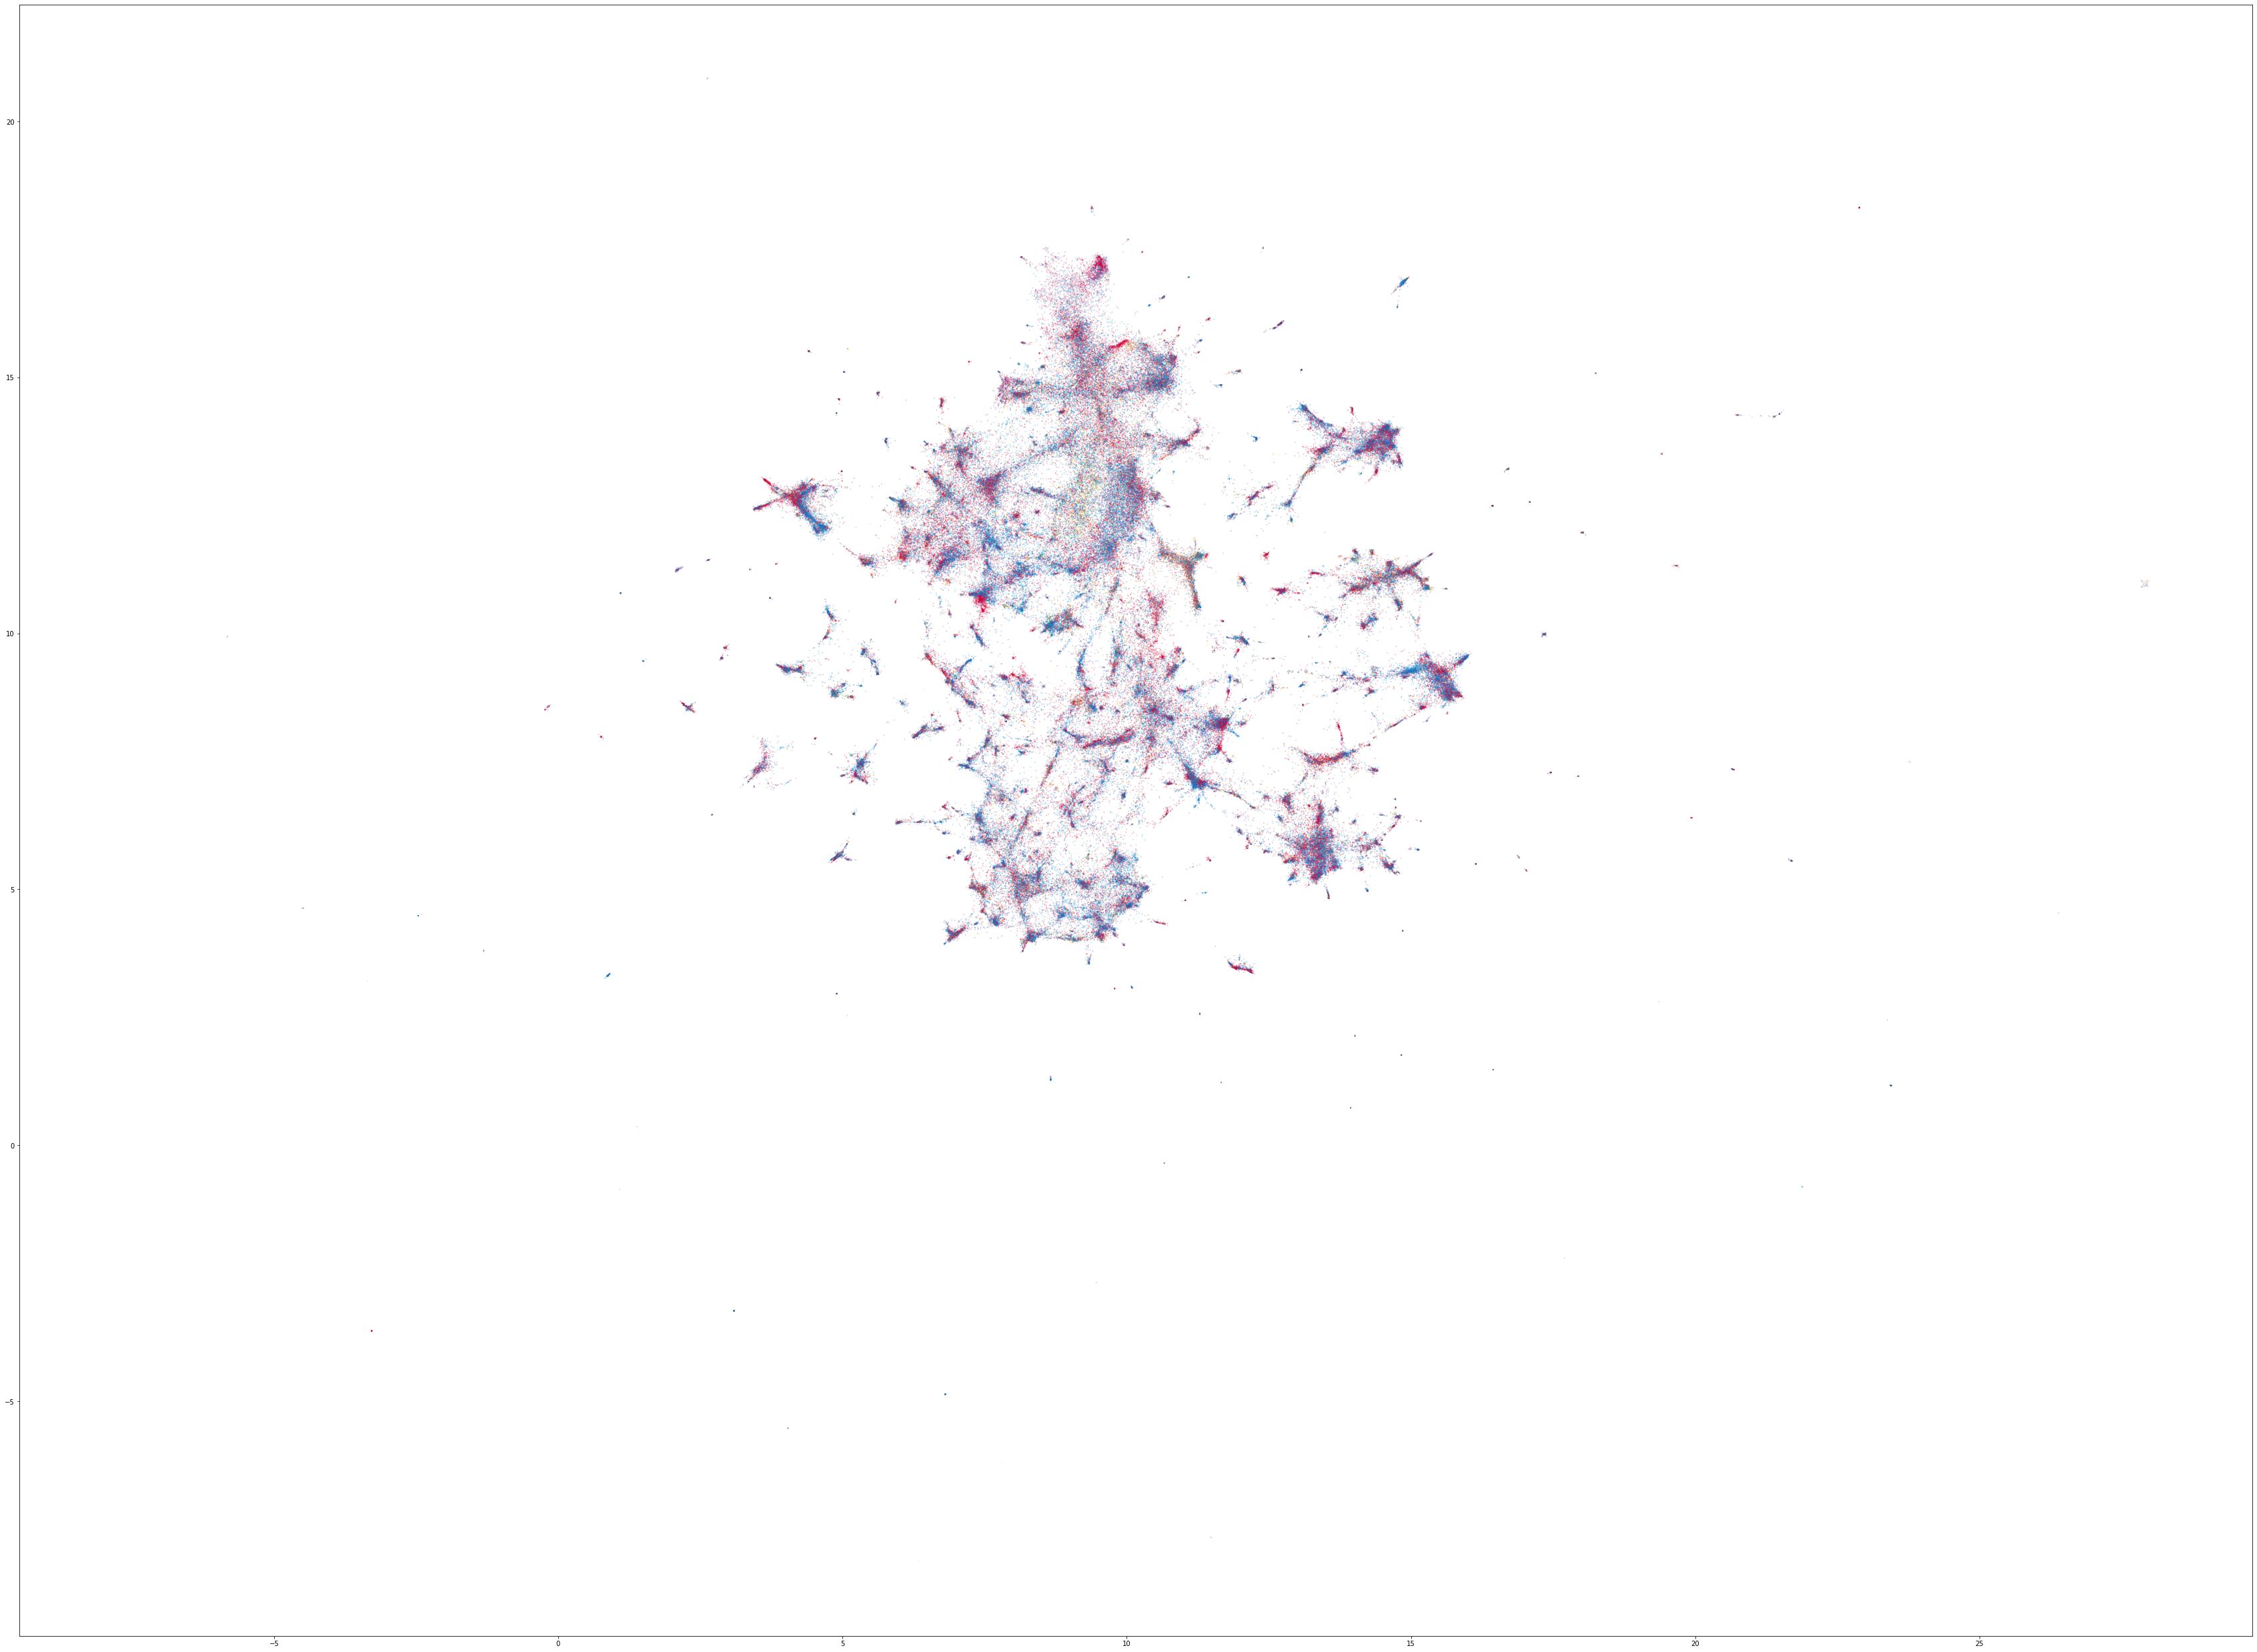

In [19]:
plt.figure(figsize=(60,45))
plt.scatter(X[:,0], X[:,1], s=1, alpha=.2, c=c)#, edgecolors='k', linewidth=0)
# plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_2.png', dpi=150)
plt.show()

# clustering

In [20]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=10,
                            min_samples=5,
                            cluster_selection_epsilon=0.018,
                            cluster_selection_method='eom')

cluster_labels = clusterer.fit_predict(X)

these parameters tuned manually - for this dataset captures clusters of different sizes and densities well

In [21]:
label_map = np.random.choice(np.arange(len(np.unique(cluster_labels)) - 1), 
                             len(np.unique(cluster_labels)) - 1,
                             replace=False)
label_map = {o:n for o,n in zip(np.arange(len(label_map)), label_map)}
label_map[-1] = -1

cluster_labels = np.array([label_map[x] for x in cluster_labels])

<ipython-input-56-7c2bf79b417a>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  cmap.set_under('black')  # Color for values less than vmin


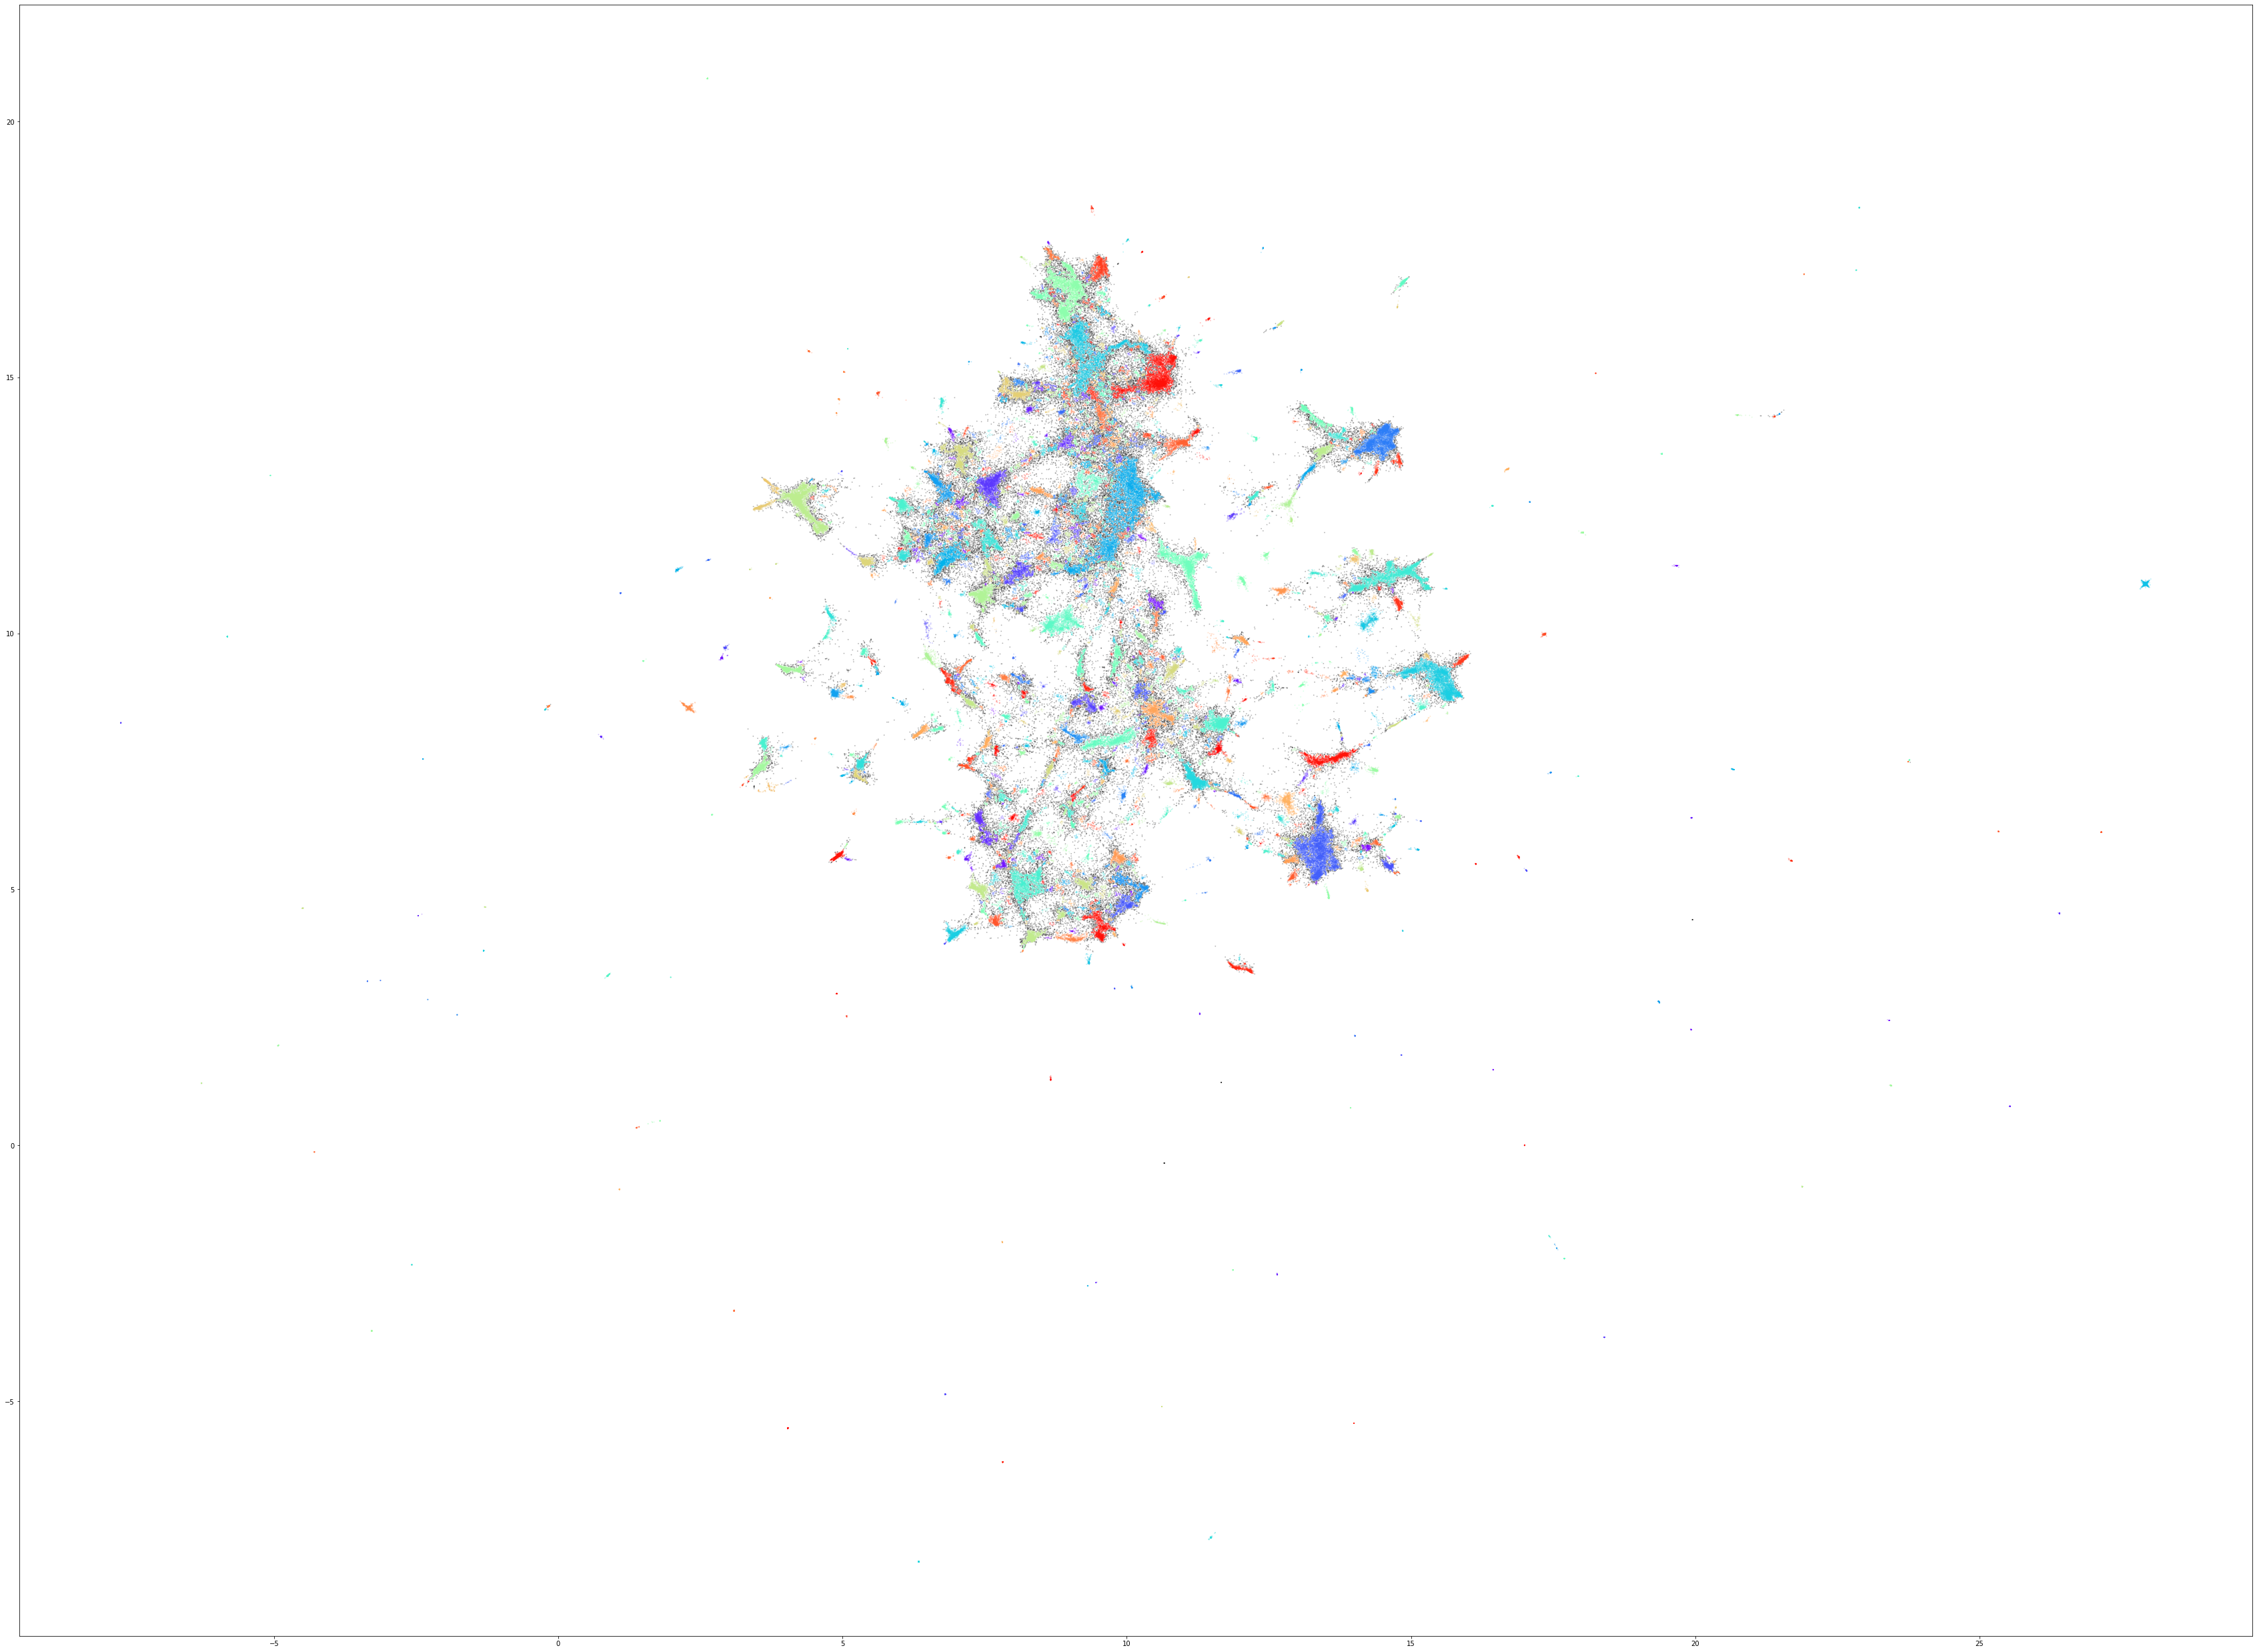

In [56]:
cmap = plt.get_cmap('rainbow')
cmap.set_under('black')  # Color for values less than vmin

plt.figure(figsize=(60,45))
plt.scatter(X[:,0], X[:,1], 
            s=1, alpha=.2, c=cluster_labels,
            cmap=cmap, vmin=0)#, edgecolors='k', linewidth=0)
plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_hdbscan4.png', dpi=200)
plt.show()

# plot centroids

In [52]:
df_proj = pd.DataFrame(X)
df_proj['cluster'] = cluster_labels

In [53]:
df_clusters = df_proj.groupby('cluster').agg({0: ['mean'], 1: ['mean'], 'cluster':[len]})

In [54]:
X_centroids = df_clusters[[0,1]].values[1:]
cluster_size = df_clusters['cluster'].values[1:]

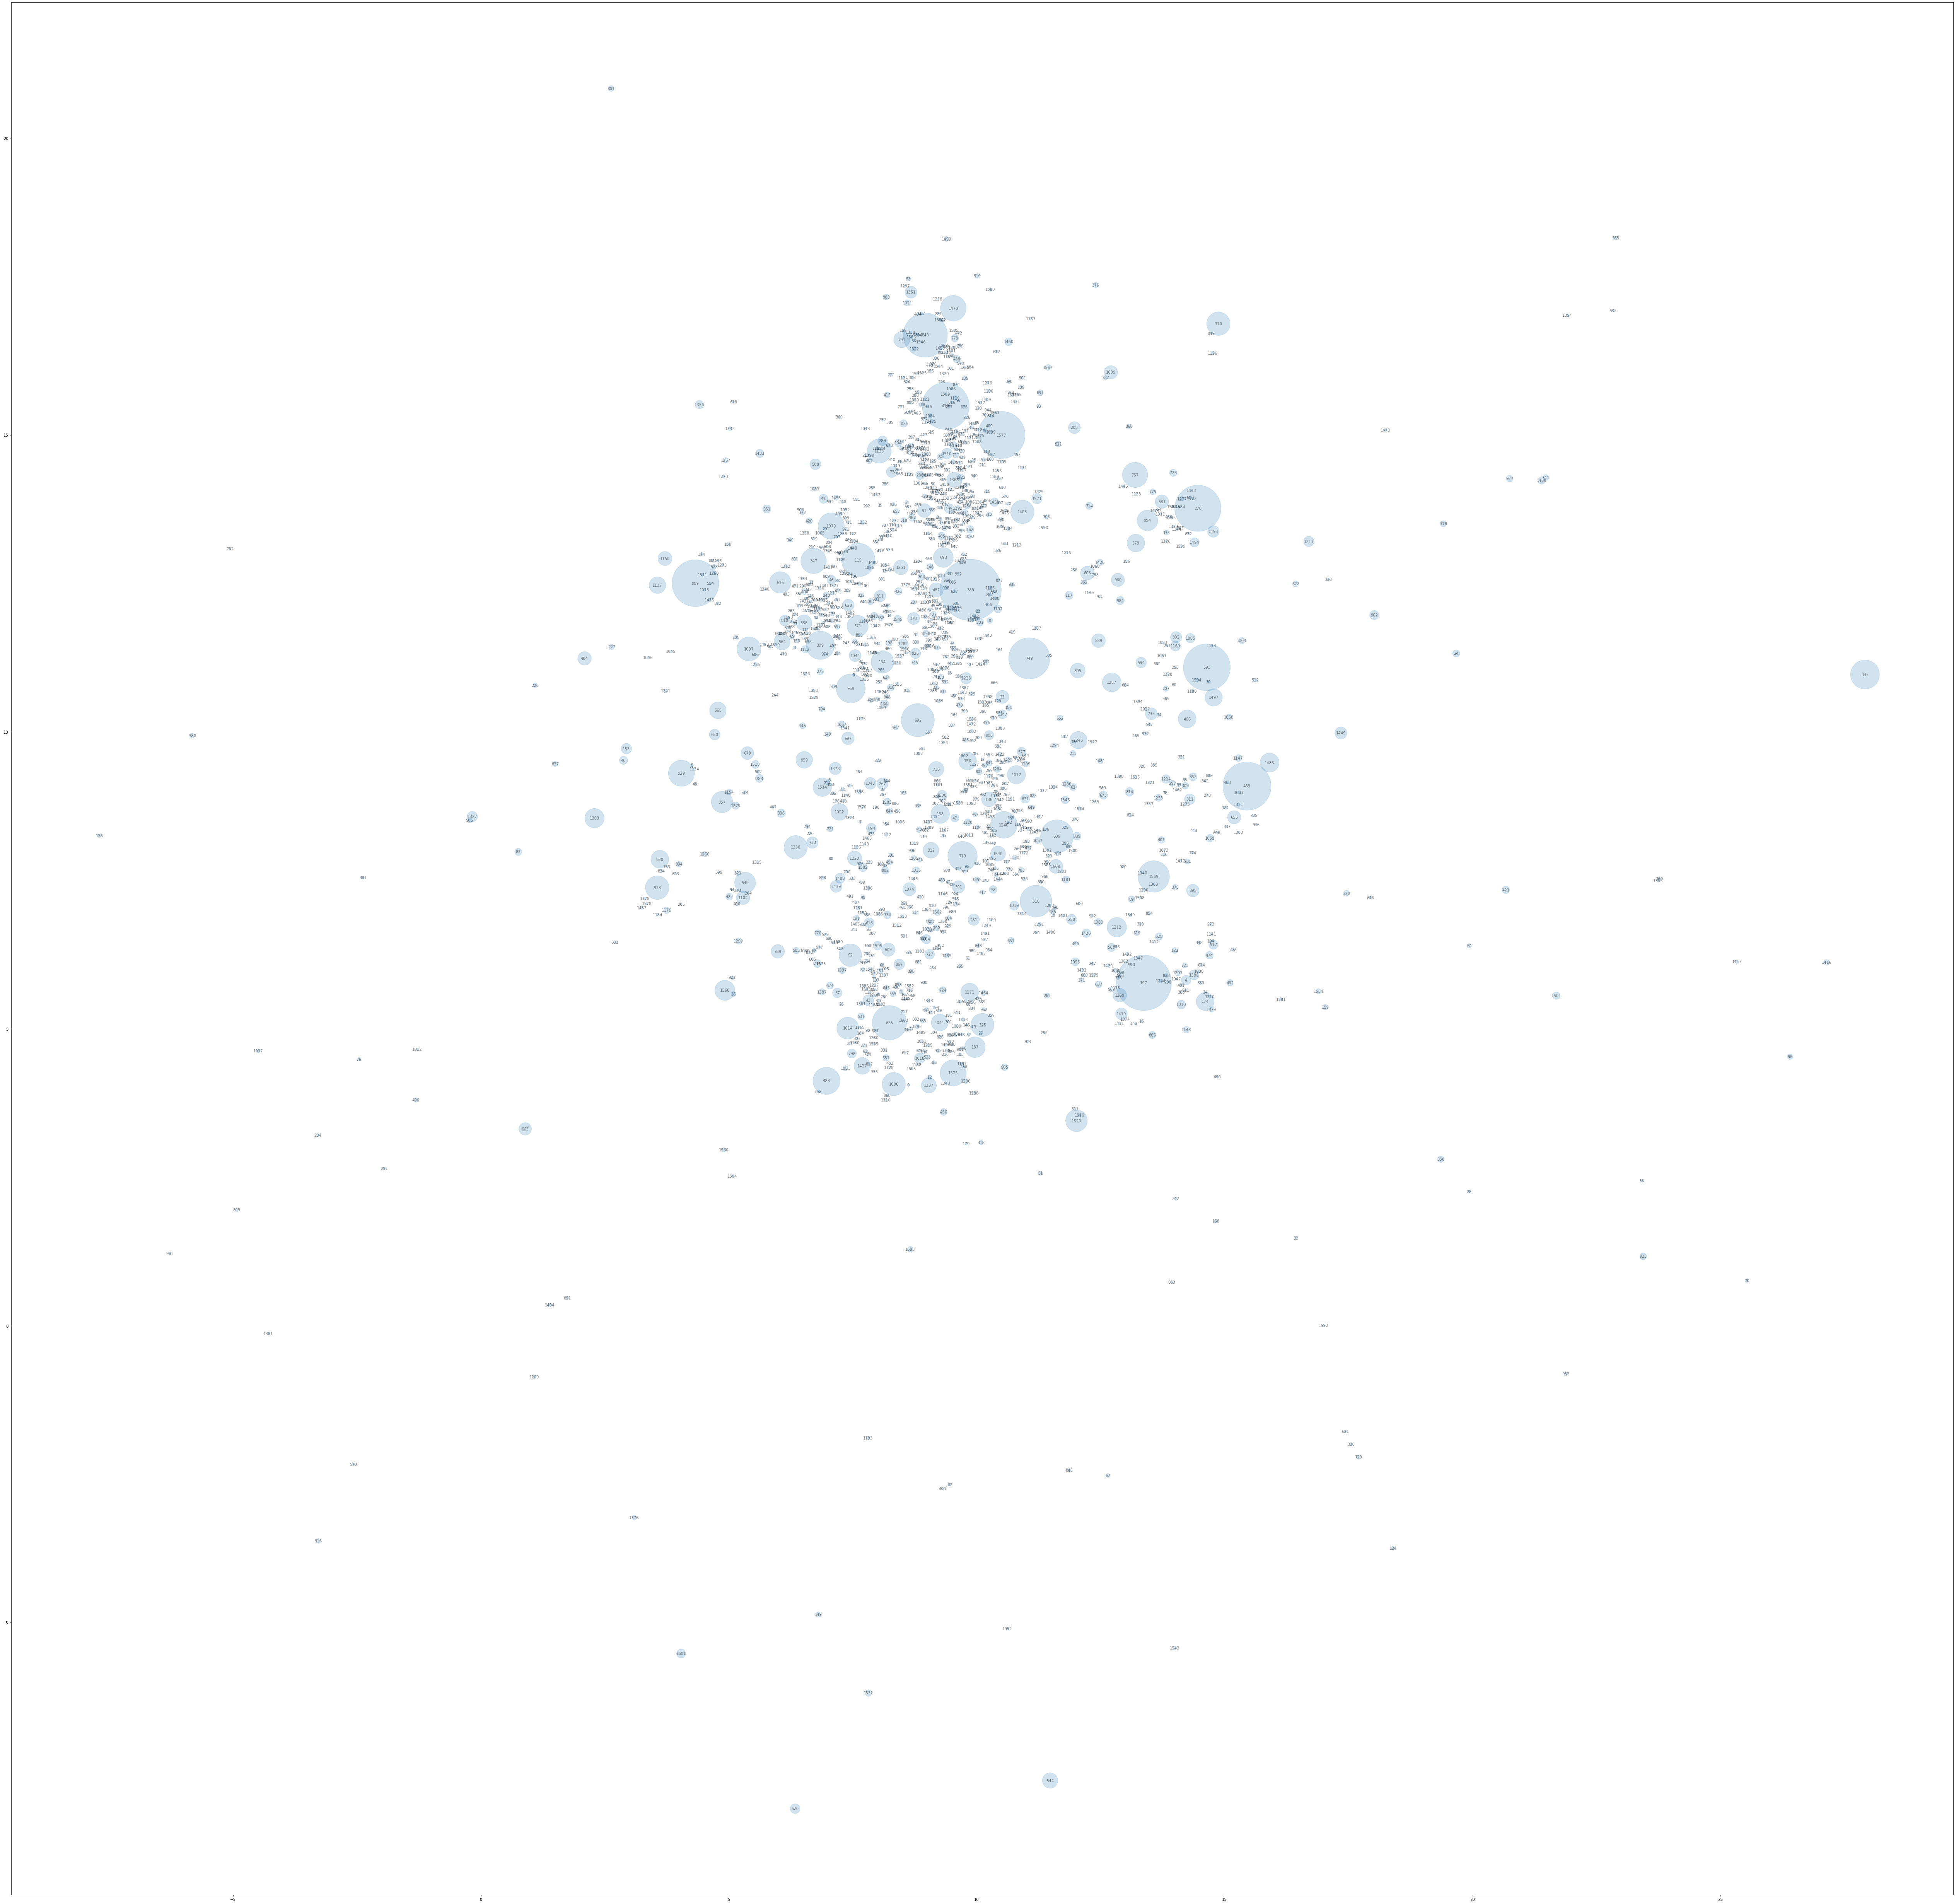

In [63]:
fig, ax = plt.subplots(figsize=(90,90))
ax.scatter(X_centroids[:,0], X_centroids[:,1], s=cluster_size*3, alpha=0.2)
for i, txt in enumerate(df_clusters.index.values[1:]):
    ax.annotate(txt, 
                (X_centroids[i,0], X_centroids[i,1]),
                ha='center', va='center',
                fontsize=10,
                alpha=0.5
               )
plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_centroids.png')

# cluster speeches EDA

In [23]:
# df['cluster'] = cluster_labels

In [24]:
df

speech  \
date       heading                                           display_as                                                           
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] Alan Beith       I usually enjoy and can be quite entertained b...   
                                                             Alan Haselhurst  Order. I should remind the hon. Gentleman and ...   
                                                             Andrew Miller    On a point of order, Mr. Speaker.It might help...   
                                                             Andrew Selous    I want to pick the right hon. Gentleman up on ...   
                                                             Andrew Smith     Would not Government members do well to rememb...   
...                                                                                                                         ...   
2019-11-05 Valedictory Debate                                Stephen Pound    May I begin by apologising, Madam Deputy Speak...   
                                                             Stephen Twigg    It is a pleasure to follow the hon. Member for...   
                                                             Teresa Pearce    I would like to thank my fantastic family, my ...   
                                                             Tim Loughton     I am very concerned and upset about my right h...   
                                                             Valerie Vaz      Thank you, Mr Speaker. I congratulate you on y...   

                                                                                                                         lemmas  \
date       heading                                           display_as                                                           
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] Alan Beith       [usually, enjoy, entertain, speech, right, hon...   
                                                             Alan Haselhurst  [order, remind, hon, gentleman, house, interve...   
                                                             Andrew Miller    [point, order, speaker, help, house, particula...   
                                                             Andrew Selous    [want, pick, right, hon, gentleman, different,...   
                                                             Andrew Smith     [government, member, remember, fine, line, div...   
...                                                                                                                         ...   
2019-11-05 Valedictory Debate                                Stephen Pound    [begin, apologise, madam, deputy, speaker, nor...   
                                                             Stephen Twigg    [pleasure, follow, hon, member, north, devon, ...   
                                                             Teresa Pearce    [like, thank, fantastic, family, friend, staff...   
                                                             Tim Loughton     [concerned, upset, right, hon, friend, departu...   
                                                             Valerie Vaz      [thank, mr, speaker, congratulate, victory, kn...   

                                                                              cluster  
date       heading                                           display_as                
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] Alan Beith            -1  
                                                             Alan Haselhurst     1238  
                                                             Andrew Miller        476  
                                                             Andrew Selous       1577  
                                                             Andrew Smith         639  
...                                                                               ...  
2019-11-0

In [25]:
groups = df.groupby('cluster')

In [26]:
df_cluster_lemmas = groups.agg({'lemmas': list})

In [27]:
df_cluster_lemmas

lemmas
cluster                                                   
-1       [[usually, enjoy, entertain, speech, right, ho...
 0       [[uk, refuse, join, state, recent, conference,...
 1       [[secretary, state, shortly, appoint, senior, ...
 2       [[revealing, debate, labour, come, house, toda...
 3       [[permission, mr, speaker, like, update, house...
...                                                    ...
 1605    [[recent, discussion, nato, counterpart, secur...
 1606    [[overwhelming, public, pressure, change, voti...
 1607    [[wellingborough, fully, integrate, interfaith...
 1608    [[education, secretary, right, level, debt, la...
 1609    [[accord, british, crime, survey, incidence, d...

[1611 rows x 1 columns]

In [28]:
def flatten(list_of_lists):
    res = []
    for l in list_of_lists:
        res += l
    return res

def flatten_lemmas(el):
    return flatten(el.values.ravel()[0])

In [29]:
cluster_lemmas = df_cluster_lemmas.apply(flatten_lemmas, axis=1)

# tfidf each cluster's lemmas

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
cluster_lemmas_joined = cluster_lemmas.apply(lambda x: " ".join(x))

In [32]:
vectorizer = TfidfVectorizer(max_df=0.8)
cluster_tfidf = vectorizer.fit_transform(cluster_lemmas_joined)

In [33]:
# with open('cluster_tfidf.pkl', 'wb') as f:
#     pickle.dump(cluster_tfidf, f)

with open('cluster_tfidf.pkl', 'rb') as f:
    cluster_tfidf = pickle.load(f)

In [34]:
cluster_tfidf.shape

(1611, 113776)

In [37]:
0 % 10

0

In [38]:
top_vocab_inds = []
n = 50
for i in range(cluster_tfidf.shape[0]):
    row = cluster_tfidf.getrow(i).toarray().ravel()
    top_vocab_inds.append(row.argsort()[::-1][:n])
    if i % 10 == 0:
        print(f'done {i}')

done 0
done 10
done 20
done 30
done 40
done 50
done 60
done 70
done 80
done 90
done 100
done 110
done 120
done 130
done 140
done 150
done 160
done 170
done 180
done 190
done 200
done 210
done 220
done 230
done 240
done 250
done 260
done 270
done 280
done 290
done 300
done 310
done 320
done 330
done 340
done 350
done 360
done 370
done 380
done 390
done 400
done 410
done 420
done 430
done 440
done 450
done 460
done 470
done 480
done 490
done 500
done 510
done 520
done 530
done 540
done 550
done 560
done 570
done 580
done 590
done 600
done 610
done 620
done 630
done 640
done 650
done 660
done 670
done 680
done 690
done 700
done 710
done 720
done 730
done 740
done 750
done 760
done 770
done 780
done 790
done 800
done 810
done 820
done 830
done 840
done 850
done 860
done 870
done 880
done 890
done 900
done 910
done 920
done 930
done 940
done 950
done 960
done 970
done 980
done 990
done 1000
done 1010
done 1020
done 1030
done 1040
done 1050
done 1060
done 1070
done 1080
done 1090
done 1100
d

In [40]:
top_vocab_inds = np.array(top_vocab_inds)

In [42]:
top_vocab_inds.shape

(1611, 50)

In [44]:
id_to_w = {v:k for k,v in vectorizer.vocabulary_.items()}

In [45]:
top_vocab_words = np.vectorize(id_to_w.get)(top_vocab_inds)

In [62]:
for i, row in enumerate(top_vocab_words):
    print(i-1, row[:6])

-1 ['bill' 'amendment' 'child' 'tax' 'local' 'business']
0 ['nuclear' 'weapon' 'conference' 'vienna' 'humanitarian' 'disarmament']
1 ['chilcot' 'foreign' 'iraq' 'blair' 'war' 'syria']
2 ['parliament' 'act' 'devolution' 'labour' 'vote' 'voter']
3 ['council' 'local' 'authority' 'rate' 'business' 'settlement']
4 ['drug' 'medicine' 'patient' 'nhs' 'pharmaceutical' 'patent']
5 ['somerset' 'pagham' 'avon' 'shipham' 'child' 'erosion']
6 ['woman' 'childcare' 'workplace' 'returner' 'return' 'child']
7 ['abortion' 'woman' 'counselling' 'act' 'pill' 'reproductive']
8 ['sleep' 'shift' 'care' 'wage' 'careworker' 'in']
9 ['croatia' 'accession' 'croatian' 'european' 'eu' 'enlargement']
10 ['tax' 'credit' 'bill' 'employment' 'benefit' 'self']
11 ['refugee' 'jordan' 'lebanon' 'syria' 'humanitarian' 'syrian']
12 ['piracy' 'nuclear' 'somaliland' 'deterrent' 'somalia' 'nato']
13 ['sunday' 'vat' 'police' 'scottish' 'sundays' 'scotland']
14 ['worker' 'union' 'scottish' 'scotland' 'trade' 'eu']
15 ['patient'